In [1]:
library(tidyverse) |> suppressMessages()
library(repr) |> suppressMessages()
library(tidymodels) |> suppressMessages()
library(cowplot) |> suppressMessages()
options(repr.matrix.max.rows = 6)
#source('tests.R')
#source("cleanup.R")

# Prediction to the risk of heart attack 

### INTRODUCTION
Heart attack happens when a part of the heart muscle doesn’t get enough blood. Nowadays, heart attack is a common and deadly disease across the world. Every year millions of people suffer from heart attacks that often result in death. Subsequently more and more people are paying attention to this matter. If we can predict someone's susceptibility to heart failure in advance, we may be able to take preventative measures and save their life!


In this project, we are trying to predict whether or not someone has a high risk of getting a heart attack. We will analyze a dataset with various factors that may influence the risks of getting heart attack. The Hungarian heart attack data is imported from UCI machine learning repository, written in .tsv format, containing 294 rows and 14 columns. One of the variables, which is “num”, is what we are trying to predict. The values of the “num” column are either 1 (high risk) or 0 (low risk). Our main research question is: **At what values of the predictors do patients have the lowest risk of heart attack, and which of our 5 predictors results in the largest increase in heart attack risk for a small deviation from this low?**

### Preliminary exploratory data analysis

##### Reading and tidying the data

In [34]:
heart_attack_data_raw = read_delim("https://raw.githubusercontent.com/RichardAdhika22/group115/main/processed.hungarian%20(1).data",delim=","
                                ,col_names=FALSE) |> suppressMessages()
colnames(heart_attack_data_raw) = c('age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num')
heart_attack_data_tidy = select(heart_attack_data_raw,-slope,-ca,-thal)
heart_attack_data_tidy = filter_all(heart_attack_data_tidy,all_vars(.!="?"))
heart_attack_data_tidy = mutate_if(heart_attack_data_tidy, is.character,as.numeric) |> mutate(num = as.factor(num)) |> mutate(sex = as.factor(sex))

heart_attack_data_tidy


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,1,2,130,132,0,2,185,0,0,0
29,1,2,120,243,0,0,160,0,0,0
30,0,1,170,237,0,1,170,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,1
58,0,2,180,393,0,0,110,1,1,1
65,1,4,130,275,0,1,115,1,1,1


##### Splitting the data into training and testing data

In [3]:
heart_attack_split = initial_split(heart_attack_data_tidy, prop = 0.75, strata = num)
heart_attack_training = training(heart_attack_split)
heart_attack_testing = testing(heart_attack_split)

In [4]:
heart_attack_data_selected = heart_attack_training |>
    select(age,sex,trestbps,chol,thalach,oldpeak,num)

heart_attack_data_selected

age,sex,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,1,130,132,185,0,0
29,1,120,243,160,0,0
31,0,100,219,150,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
54,0,130,294,100,0,1
56,1,155,342,150,3,1
58,0,180,393,110,1,1


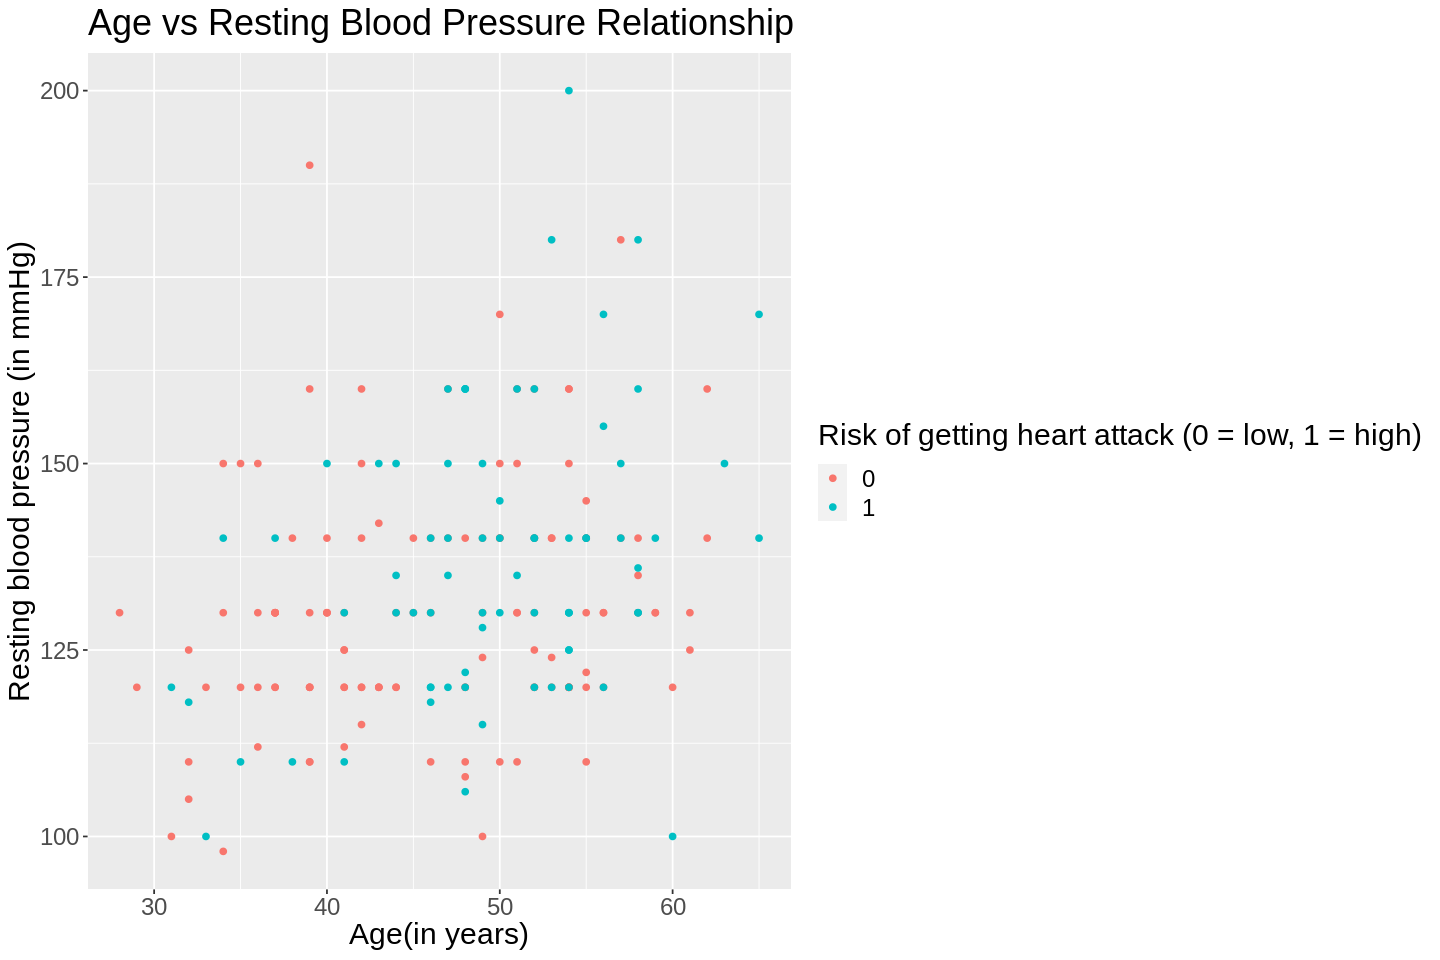

In [5]:
options(repr.plot.width=12, repr.plot.height=8)

age_vs_trestbps = ggplot(heart_attack_data_selected,aes(x=age,y=trestbps,color=num))+
    geom_point() +
    labs(x = "Age(in years)",y = "Resting blood pressure (in mmHg)", color = "Risk of getting heart attack (0 = low, 1 = high)")+
    ggtitle("Age vs Resting Blood Pressure Relationship")+
    theme(text = element_text(size=18))

age_vs_trestbps

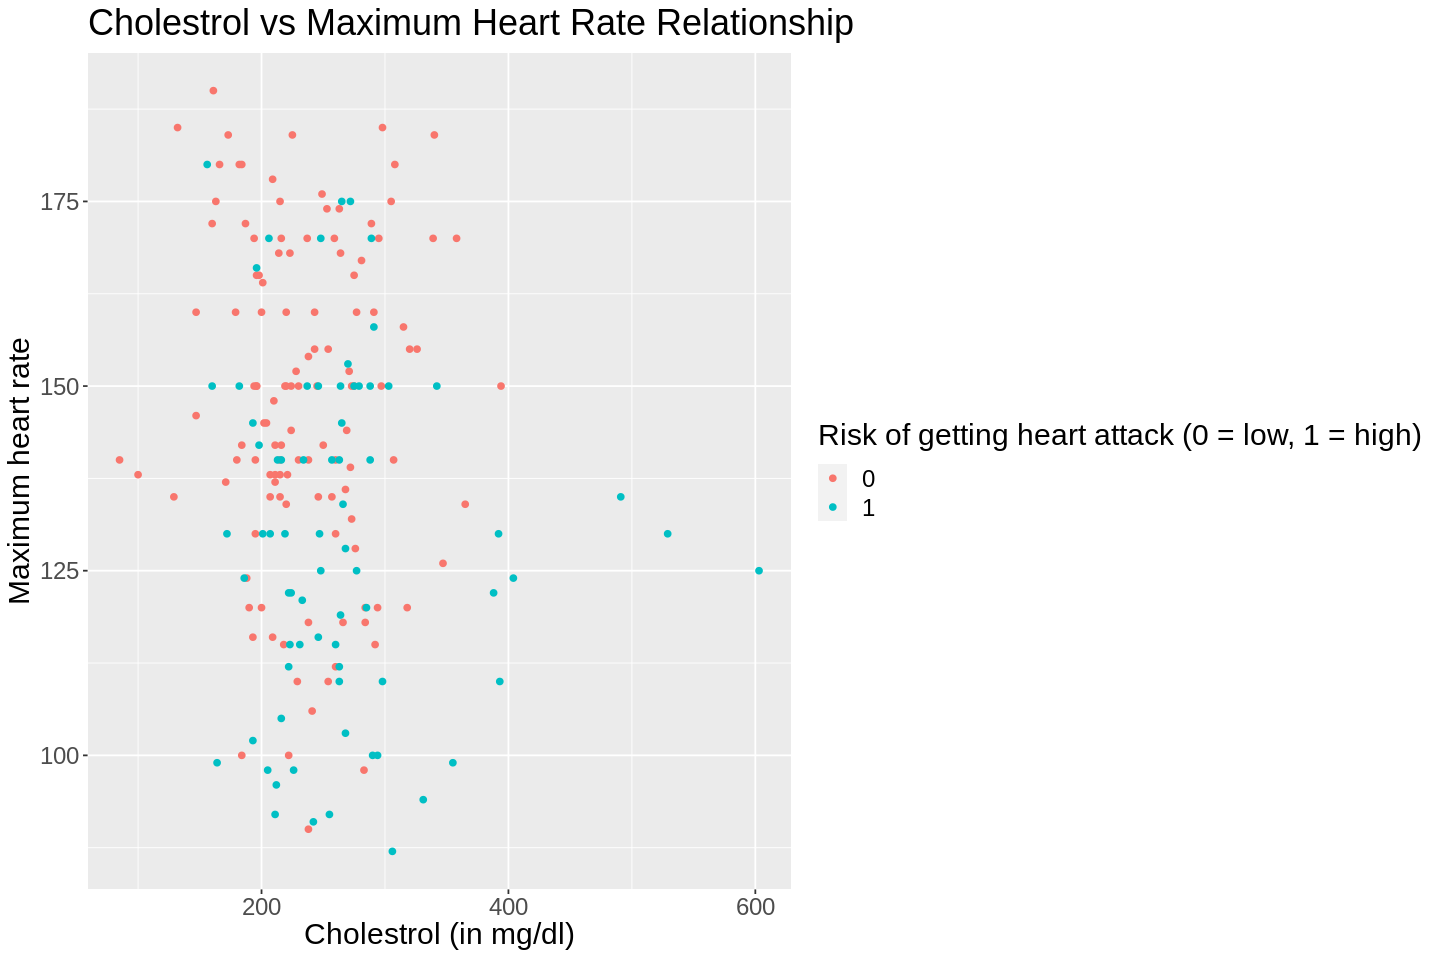

In [6]:
chol_vs_thalach = ggplot(heart_attack_data_selected,aes(x = chol,y = thalach,color=num))+
    geom_point() +
    labs(x = "Cholestrol (in mg/dl)",y = "Maximum heart rate", color = "Risk of getting heart attack (0 = low, 1 = high)")+
    ggtitle("Cholestrol vs Maximum Heart Rate Relationship")+
    theme(text = element_text(size=18))

chol_vs_thalach

##### Average of each predictor variables

In [7]:
table_means = select(heart_attack_data_selected,-sex) |>
    group_by(num) |>
    summarize(across(age:oldpeak,.fns=list('mean'=mean,'sd'=sd)))

table_means

num,age_mean,age_sd,trestbps_mean,trestbps_sd,chol_mean,chol_sd,thalach_mean,thalach_sd,oldpeak_mean,oldpeak_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,46.22951,8.324798,130.3852,16.09448,235.2869,53.91123,147.5820,22.16610,0.2483607,0.5630838
1,49.64384,7.360499,136.9589,19.05142,265.6027,78.93365,128.9863,23.30385,1.1849315,0.9842751


##### Amount of each class

In [41]:
total_amount = heart_attack_data_selected |>
    summarize("total"=n())|>
    pull()

table_num_count = heart_attack_data_selected |>
    group_by(num) |>
    summarize("total_number_of_num" = n())|>
    mutate("percentage" = total_number_of_num/total_amount*100)

table_num_count 

num,total_number_of_num,percentage
<fct>,<int>,<dbl>
0,122,62.5641
1,73,37.4359


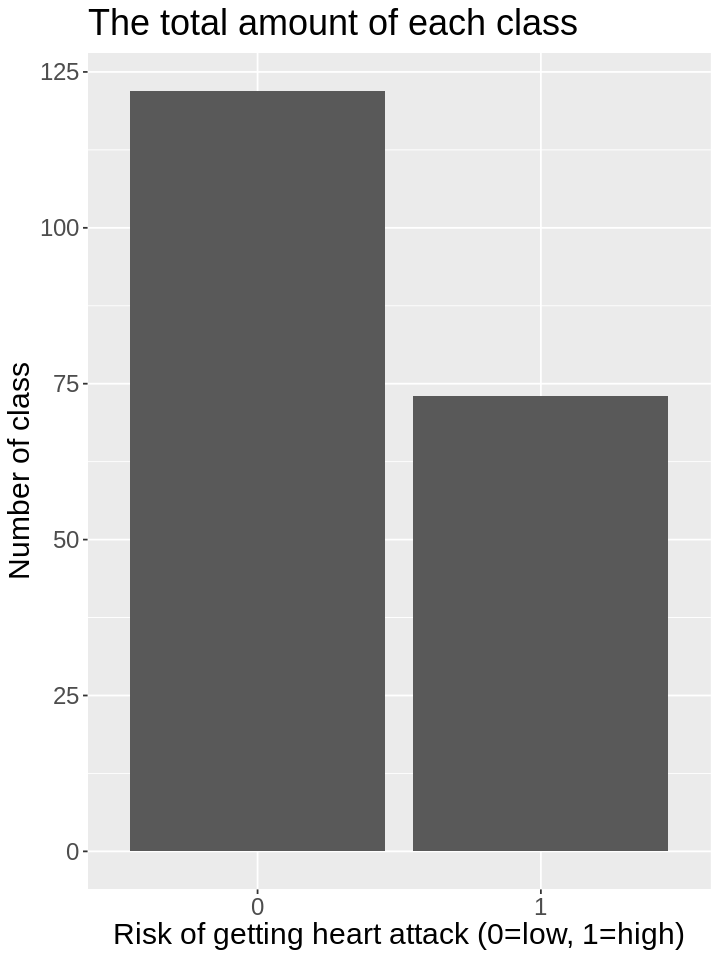

In [42]:
options(repr.plot.width=6, repr.plot.height=8)

num_count_plot = table_num_count |>
    ggplot(aes(x = num, y = total_number_of_num))+
    geom_bar(stat="identity")+
    labs(x = "Risk of getting heart attack (0=low, 1=high)", y = "Number of class")+
    ggtitle("The total amount of each class")+
    theme(text = element_text(size=18))

num_count_plot

### The number of omitted observations

In [10]:
missing_data = nrow(heart_attack_data_raw) - nrow(heart_attack_data_tidy)
missing_data

[1] 33

In [43]:
value_count = pull(table_num_count, total_number_of_num)

summary_table = bind_cols(table_means,value_count) |> suppressMessages()
names(summary_table)[names(summary_table) == '...12'] <- 'total_number_of_num'
summary_table

num,age_mean,age_sd,trestbps_mean,trestbps_sd,chol_mean,chol_sd,thalach_mean,thalach_sd,oldpeak_mean,oldpeak_sd,total_number_of_num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,46.22951,8.324798,130.3852,16.09448,235.2869,53.91123,147.5820,22.16610,0.2483607,0.5630838,122
1,49.64384,7.360499,136.9589,19.05142,265.6027,78.93365,128.9863,23.30385,1.1849315,0.9842751,73


### Distributions

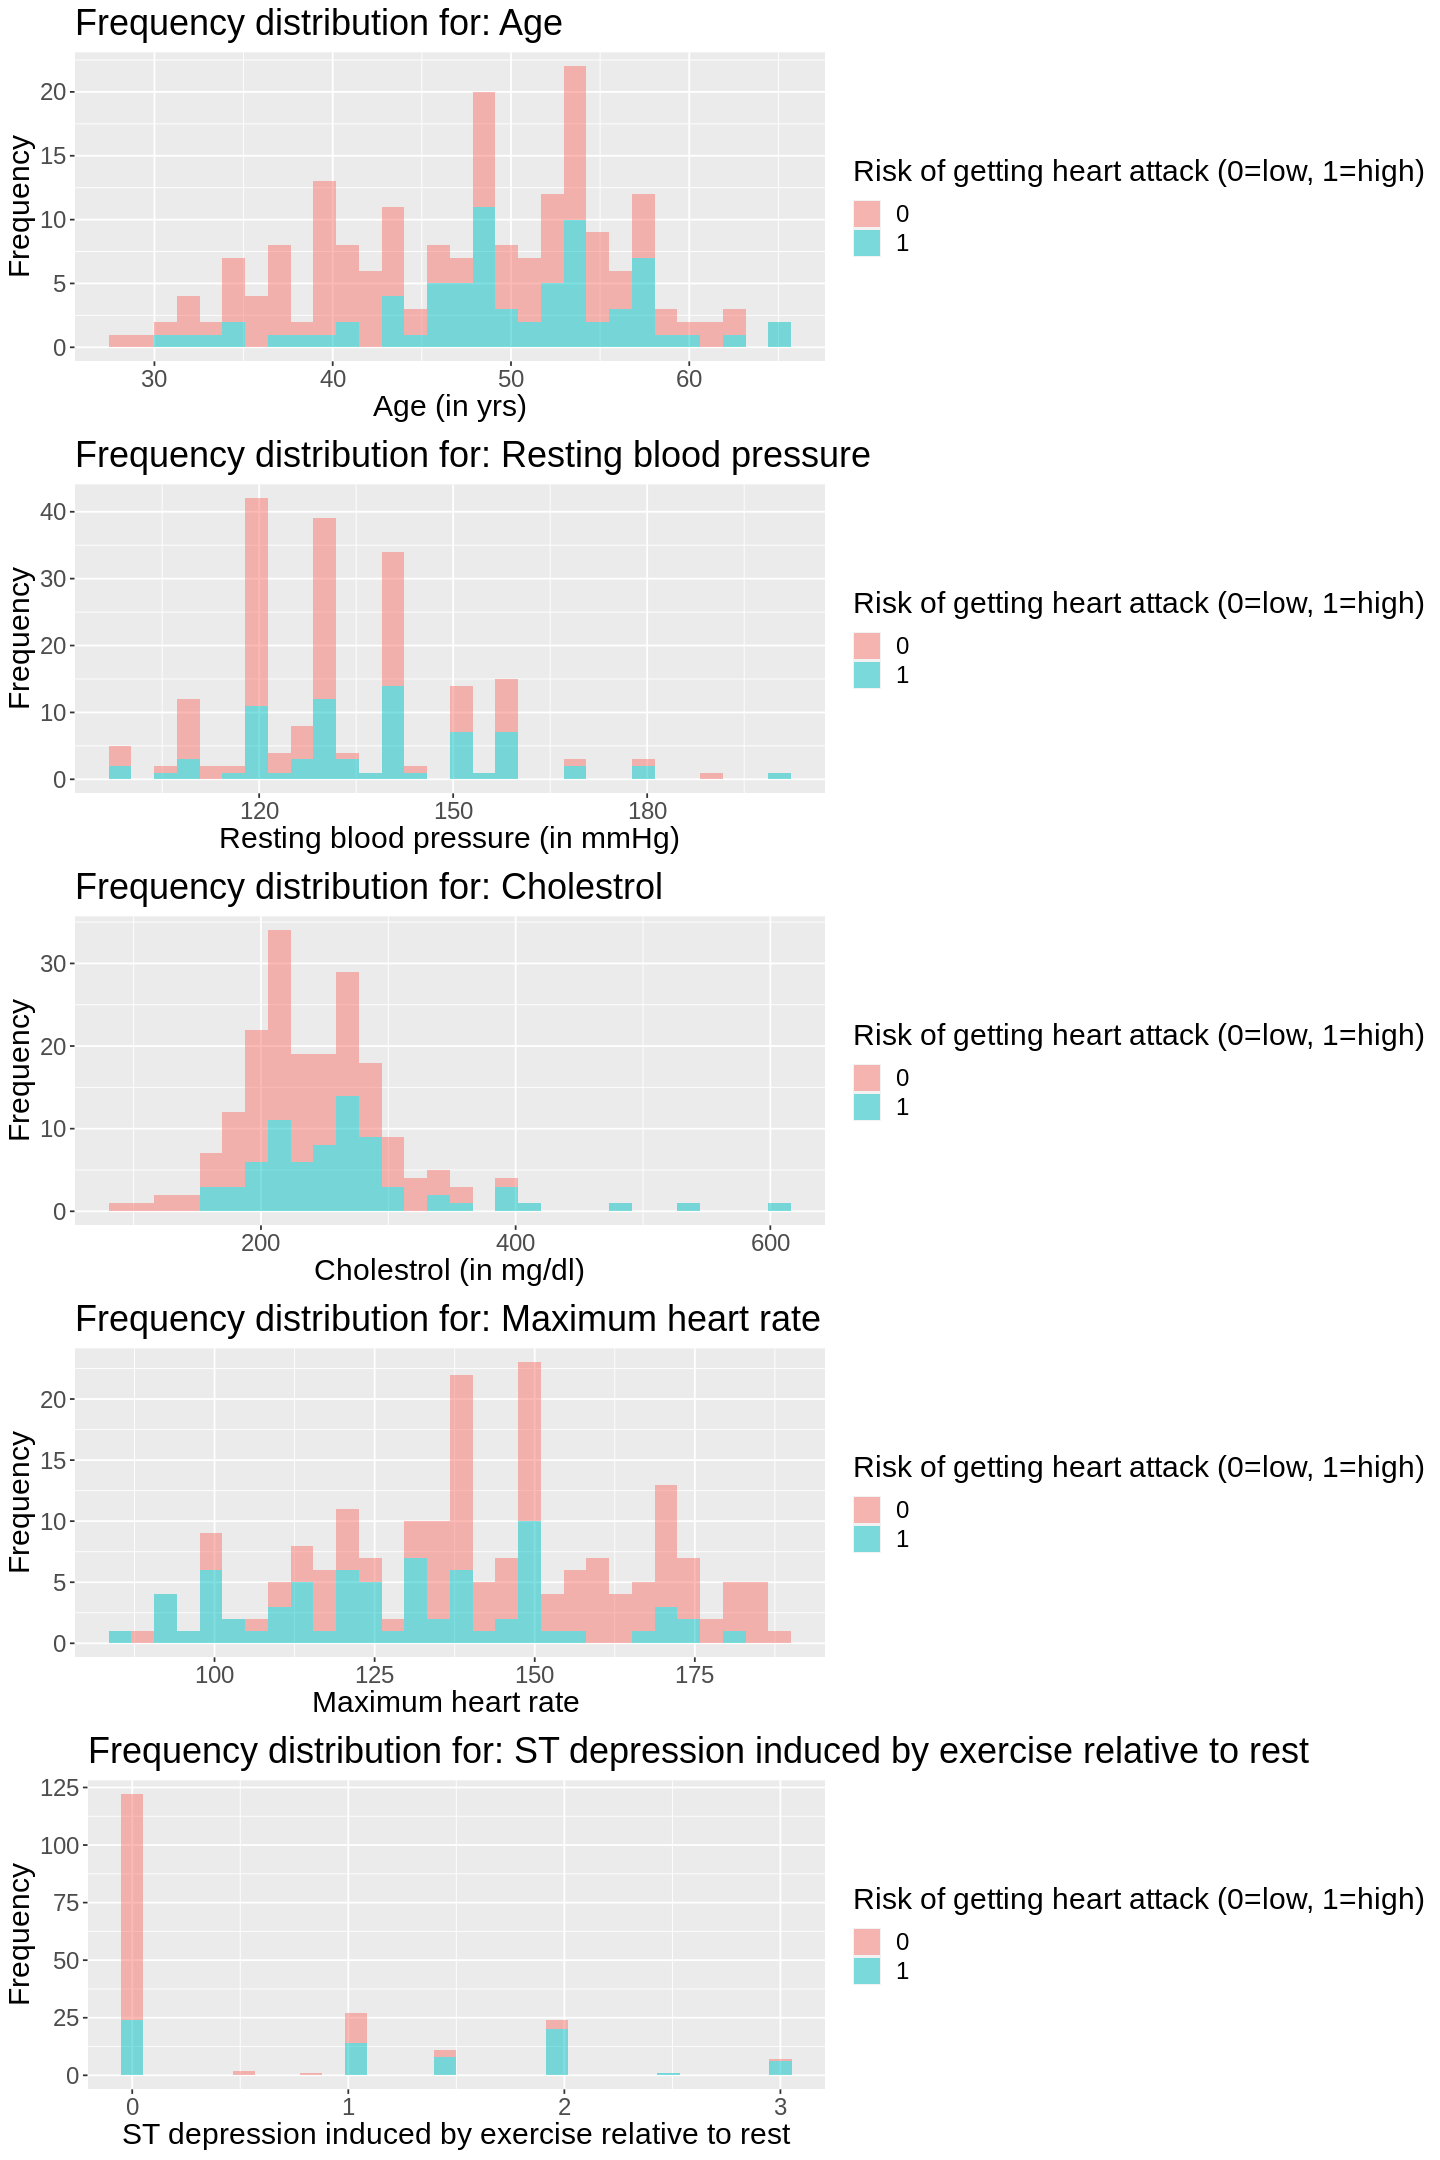

In [32]:
# age_hist = hist(raw_age,main="Histogram of age distribution",xlab="Age",ylab="Frequency")
# trestbps_hist = hist(raw_trestbps,main="Histogram of trestbps distribution",xlab="Age",ylab="Frequency")
# chol_hist = hist(raw_chol,main="Histogram of chol distribution",xlab="Age",ylab="Frequency")
# thalach_hist = hist(raw_thalach,main="Histogram of thalach distribution",xlab="Age",ylab="Frequency")
# oldpeak_hist = hist(raw_oldpeak,main="Histogram of oldpeak distribution",xlab="Age",ylab="Frequency")

options(repr.plot.width=12, repr.plot.height=18)

age_hist = heart_attack_data_selected |>
    ggplot(aes(x=age, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Age (in yrs)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Age")+
    theme(text = element_text(size=18))

trestbps_hist = heart_attack_data_selected |>
    ggplot(aes(x=trestbps, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Resting blood pressure (in mmHg)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Resting blood pressure")+
    theme(text = element_text(size=18))

chol_hist = heart_attack_data_selected |>
    ggplot(aes(x=chol, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Cholestrol (in mg/dl)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Cholestrol")+
    theme(text = element_text(size=18))

thalach_hist = heart_attack_data_selected |>
    ggplot(aes(x=thalach, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Maximum heart rate ", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Maximum heart rate")+
    theme(text = element_text(size=18))

oldpeak_hist = heart_attack_data_selected |>
    ggplot(aes(x=oldpeak, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "ST depression induced by exercise relative to rest", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: ST depression induced by exercise relative to rest")+
    theme(text = element_text(size=18))

plot_grid(age_hist, trestbps_hist, chol_hist, thalach_hist, oldpeak_hist, ncol=1)


### Methods

Columns/Variables as predictor variables:
We choose these 5 variables as our predictors because all of them have the “double” type, so that the prediction will be more reasonable and accurate compared to the factor type. 
* Age in years
* Resting blood pressure in mmHg (trestbps)
* Cholesterol in mg/dl fetched by BMI sensor (chol)
* Maximum heart rate achieved (thalach)
* ST depression induced by exercise relative to rest (oldpeak)

Since our class (num) takes on only two values (0 for low risk of heart attack and 1 for high risk), we will use K nearest neighbor classification analysis. One way to visualize the results of prediction is to make a line plot on how different values of K affect the accuration of the prediction so that we can choose the K that has the highest accuracy. Another visualization we plan to make is a scatter plot showing the relationship between two of the predictor variables we are interested in. Then, we can separate the plot into two regions with different colors to mark each factor from our prediction result.


### Expected outcomes and significance

By building a prediction of the risk of heart attack, not only can we calculate the accuracy of our prediction, but we can also find out whether those four predictor variables that we chose are suitable in our model or not. Low accuracy of prediction means that we should do something about the predictor variables (assuming the data itself is accurate) by changing the variables that we use (include additional variables and/or remove unsuitable ones). 

In doing our analysis, we expect to find correlations between each of the predictor variables and the risk of heart attack. We expect that for each predictor there will be a range of values for which the risk of heart attack is low, and the more that a predictor deviates from this range the more likely the given observation will have num = 1. We can use our visualizations above to help us with this analysis- for example, we can use the histograms to check where the risk of heart attack is lowest, and observe how the proportion of high and low risk changes as we move across a predictor's histogram.

Doing the prediction of the risk of heart attack may save people’s lives. Some people might not realize that they have a high risk heart attack until they have a medical check-up. After knowing it, they can take some medication and change their lifestyle to reduce the risk of getting a heart attack. Our project can help doctors make more accurate predictions on heart attack risk and potentially save more patients.

Some questions that might appear in the future regarding this prediction: 
* Are there any additional predictor variables to be added into consideration when predicting the risk of heart attack?
* Is the accuracy of this prediction high enough to be used in a real world situation?
